In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import ElasticNet, Lasso
from sklearn.metrics import mean_squared_error, median_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
)
from sklearn_pandas import DataFrameMapper, gen_features

plt.style.use("seaborn-talk")


set_config(display="diagram")

In [3]:
data_file = "../data/data.csv"

# Assumptions

1. Dataset is small and it is reasonable to load multiple times and run quick iterations of models
2. Models that can aid interpretation are important.

# Exploratory data analysis

In [4]:
df = pd.read_csv(data_file, sep=";")

In [5]:
df.describe()

,Y,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9
count,1436.000000,1436.000000,1436.000000,414.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.00000
mean,10730.824513,55.947075,68533.259749,0.173913,101.502089,0.674791,0.055710,1566.827994,4.033426,1072.45961
std,3626.964585,18.599988,37506.448872,0.379493,14.981080,0.468616,0.229441,187.182436,0.952677,52.64112
min,4350.000000,1.000000,1.000000,0.000000,69.000000,0.000000,0.000000,1300.000000,2.000000,1000.00000
25%,8450.000000,44.000000,43000.000000,0.000000,90.000000,0.000000,0.000000,1400.000000,3.000000,1040.00000
50%,9900.000000,61.000000,63389.500000,0.000000,110.000000,1.000000,0.000000,1600.000000,4.000000,1070.00000
75%,11950.000000,70.000000,87020.750000,0.000000,110.000000,1.000000,0.000000,1600.000000,5.000000,1085.00000
max,32500.000000,80.000000,243000.000000,1.000000,192.000000,1.000000,1.000000,2000.000000,5.000000,1615.00000


In [6]:
# % missing values
df.isnull().sum()/len(df)*100

Y             0.000000
Feature 1     0.000000
Feature 2     0.000000
Feature 3    71.169916
Feature 4     0.000000
Feature 5     0.000000
Feature 6     0.000000
Feature 7     0.000000
Feature 8     0.000000
Feature 9     0.000000
dtype: float64

Feature 3 can be dropped for now. We will see later if null values of Feature 3 can be assigned as a separate class and one hot encoded.

*** TODO: Use Feature 3 or not

In [7]:
df.head()

,Y,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9
0,13500,23,46986,1.0,90,1,0,2000,3,1165
1,13750,23,72937,1.0,90,1,0,2000,3,1165
2,13950,24,41711,1.0,90,1,0,2000,3,1165
3,14950,26,48000,1.0,90,0,0,2000,3,1165
4,13750,30,38500,1.0,90,0,0,2000,3,1170


<ipython-input-8-fb66037a4274>:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  scatter_matrix(df, ax=ax)


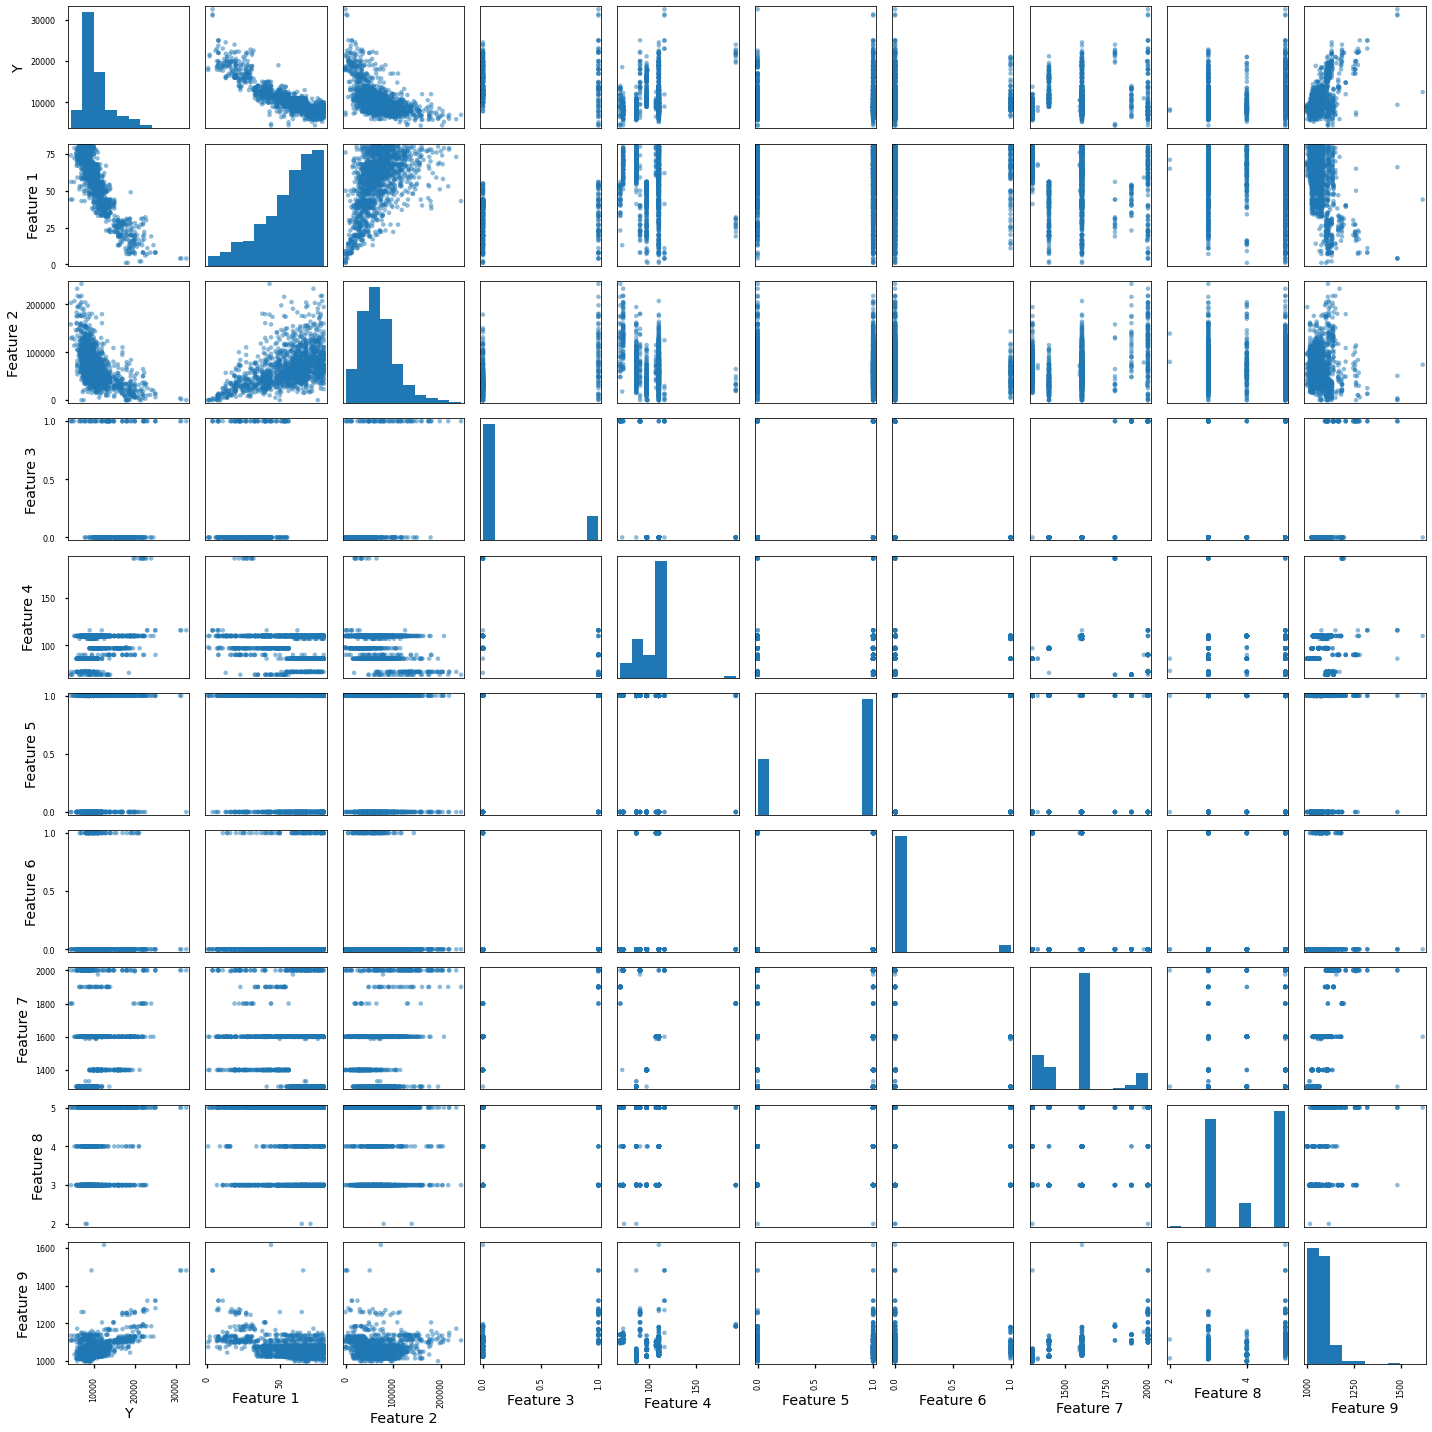

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
scatter_matrix(df, ax=ax)
plt.tight_layout()

## Quick observations:

Univariate
- Y is not normally distrubted. Also, the range of values is high. If not standardized, this create problems in model fitting
- Feature 1 and Feature 2 may need to be normalized
- Feature 5 and Feature 6 can be treated as categorical variables
- Feature 7 and Feature 9 may need to be normalized 
- Feature 8 can be treated as categorical variables. One hot encoding vs using it as ordinal is a choice for later
- For feature 1, more samples available at higher values
- Since Feature 3 has missing values, it will be handled separately in this case

Multivariate
- Feature 1 and Y are negatively correlated
- Feature 2 and Y are negatively correlated

In [9]:
# TODO: Do box plots to identify outliers

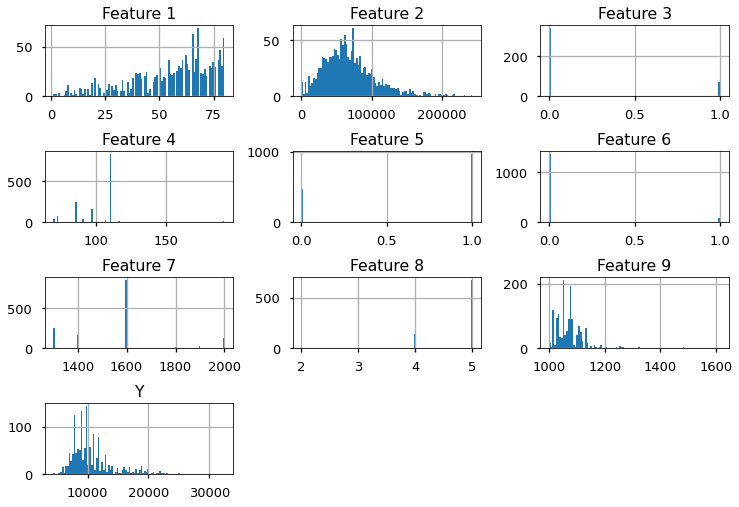

In [10]:
df.hist(bins=100)
plt.tight_layout()

Text(0.5, 1.0, 'Mean = -0.00, Std = 1.00')

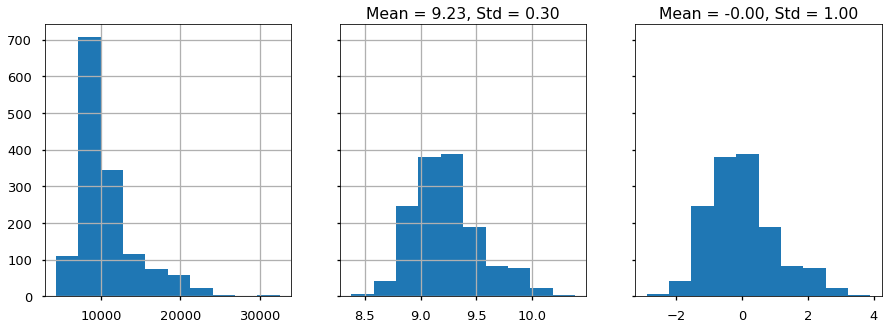

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
df["Y"].hist(ax=ax[0])
trans_y = df["Y"].apply(lambda x: np.log(x))
mean_trans_y = trans_y.mean()
std_trans_y = trans_y.std()
trans_y.hist(ax=ax[1])
ax[1].set_title(f"Mean = {mean_trans_y:.2f}, Std = {std_trans_y:.2f}")
# scaler = PowerTransformer(method='box-cox', standardize=True)
scaler = StandardScaler()

standard_trans_y = scaler.fit_transform(trans_y.values.reshape(-1, 1))
mean_trans_y = standard_trans_y.mean()
std_trans_y = standard_trans_y.std()
ax[2].hist(standard_trans_y)
ax[2].set_title(f"Mean = {mean_trans_y:.2f}, Std = {std_trans_y:.2f}")
# TODO: Box-cox gives better transform?

### Feature 1

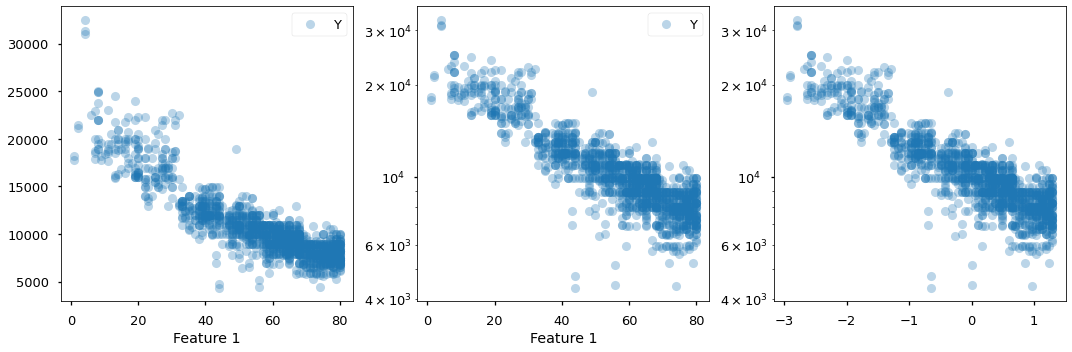

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax = ax.flatten()
df.plot("Feature 1", "Y", style="o", ax=ax[0], alpha=0.3)
df.plot("Feature 1", "Y", style="o", ax=ax[1], alpha=0.3)
ax[1].set_yscale("log")
ax[2].plot(
    StandardScaler().fit_transform(df["Feature 1"].values.reshape(-1, 1)),
    df["Y"],
    "o",
    alpha=0.3,
)
ax[2].set_yscale("log")
# ax[2].set_xscale("log", basex=2)
plt.tight_layout()

### Feature 2

Potential outliers: "Feature 2" < 1000

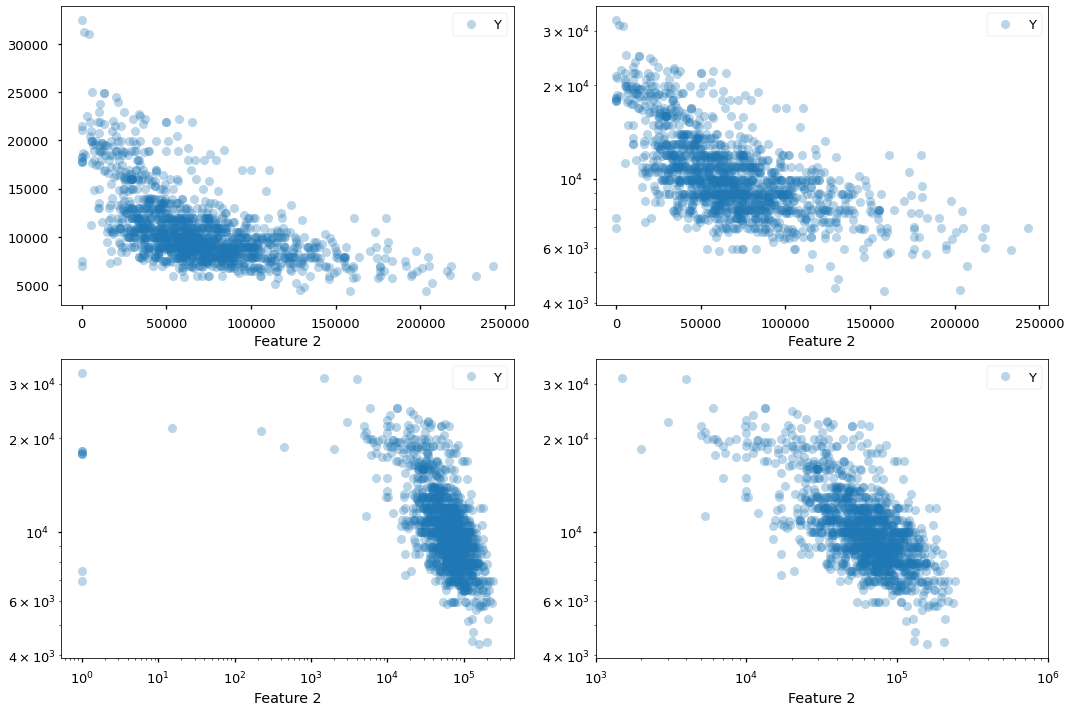

In [13]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
ax = ax.flatten()
df.plot("Feature 2", "Y", style="o", ax=ax[0], alpha=0.3)
df.plot("Feature 2", "Y", style="o", ax=ax[1], alpha=0.3)
ax[1].set_yscale("log")
df.plot("Feature 2", "Y", style="o", ax=ax[2], alpha=0.3)
ax[2].set_yscale("log")
ax[2].set_xscale("log")
df.plot("Feature 2", "Y", style="o", ax=ax[3], alpha=0.3)
ax[3].set_yscale("log")
ax[3].set_xscale("log")
ax[3].set_xlim(1000, 1000000)
plt.tight_layout()

### Feature 3

In [14]:
df["Feature 3"].value_counts(dropna=False)

NaN    1022
0.0     342
1.0      72
Name: Feature 3, dtype: int64

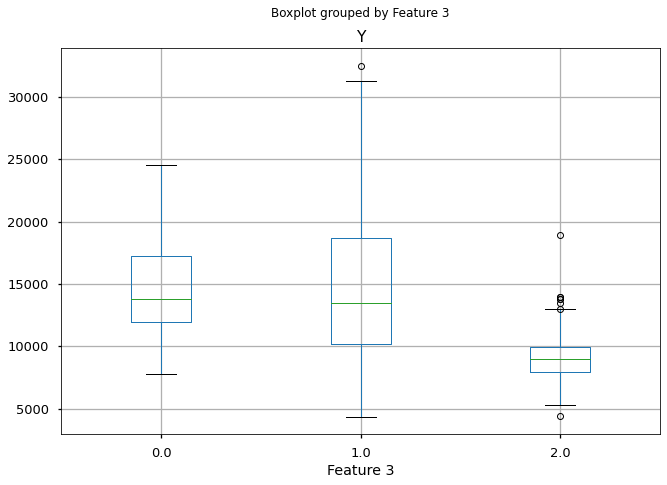

In [15]:
df.fillna(value={"Feature 3": 2}).boxplot(
    "Y", by="Feature 3",
)

Average response with Feature 3 is missing, is visibly less compared to other states.
With minimum infomration about the cause of missing values, we have two options - 
1. Consider missing values as separate category.
2. Ignore Column 3

We will try out both and observe how model results change

### Feature 9

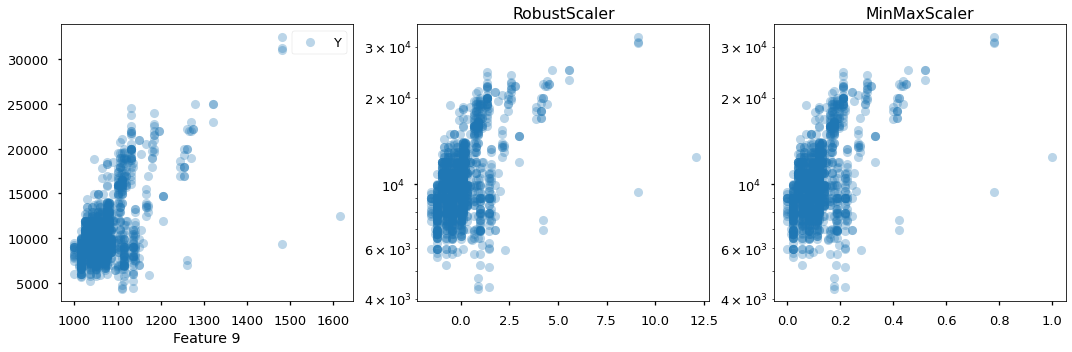

In [16]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax = ax.flatten()
df.plot("Feature 9", "Y", style="o", ax=ax[0], alpha=0.3)
ax[1].plot(
    RobustScaler().fit_transform(df["Feature 9"].values.reshape(-1, 1)),
    df["Y"],
    "o",
    alpha=0.3,
)
ax[1].set_yscale("log")
ax[1].set_title("RobustScaler")
ax[2].plot(
    MinMaxScaler().fit_transform(df["Feature 9"].values.reshape(-1, 1)),
    df["Y"],
    "o",
    alpha=0.3,
)
ax[2].set_title("MinMaxScaler")
ax[2].set_yscale("log")
plt.tight_layout()

### Feature 5,6,8

In [17]:
df["Feature 5"].value_counts()

1    969
0    467
Name: Feature 5, dtype: int64

In [18]:
df["Feature 6"].value_counts()

0    1356
1      80
Name: Feature 6, dtype: int64

In [19]:
df["Feature 8"].value_counts()

5    674
3    622
4    138
2      2
Name: Feature 8, dtype: int64

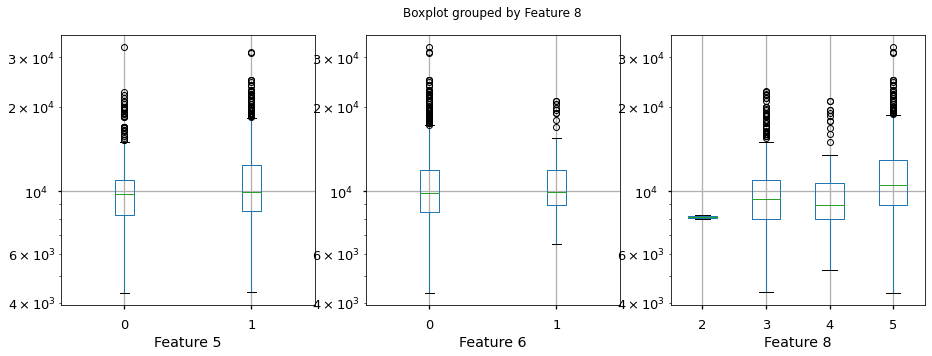

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for c, ax in zip(["Feature 5", "Feature 6", "Feature 8"], axes):
    df.boxplot("Y", by=c, ax=ax)
    ax.set_yscale("log")
    ax.set_title("")

### Feature 4

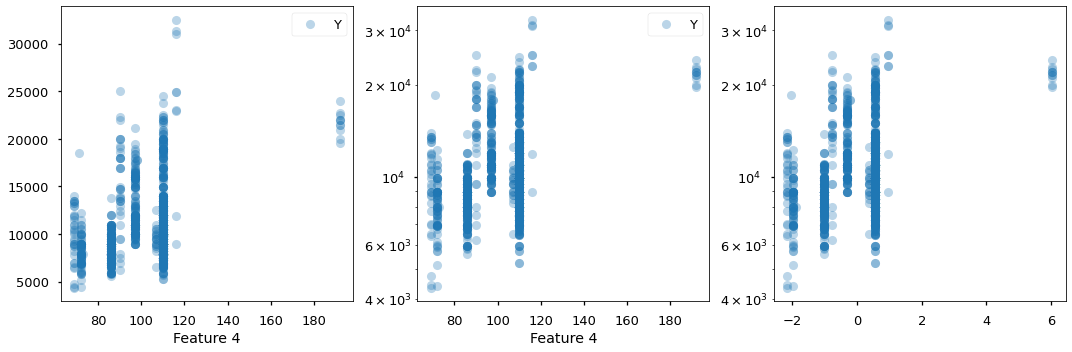

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax = ax.flatten()
df.plot("Feature 4", "Y", style="o", ax=ax[0], alpha=0.3)
df.plot("Feature 4", "Y", style="o", ax=ax[1], alpha=0.3)
ax[1].set_yscale("log")
ax[2].plot(
    StandardScaler().fit_transform(df["Feature 4"].values.reshape(-1, 1)),
    df["Y"],
    "o",
    alpha=0.3,
)
ax[2].set_yscale("log")
# ax[2].set_xscale("log", basex=2)
plt.tight_layout()

### Feature 7

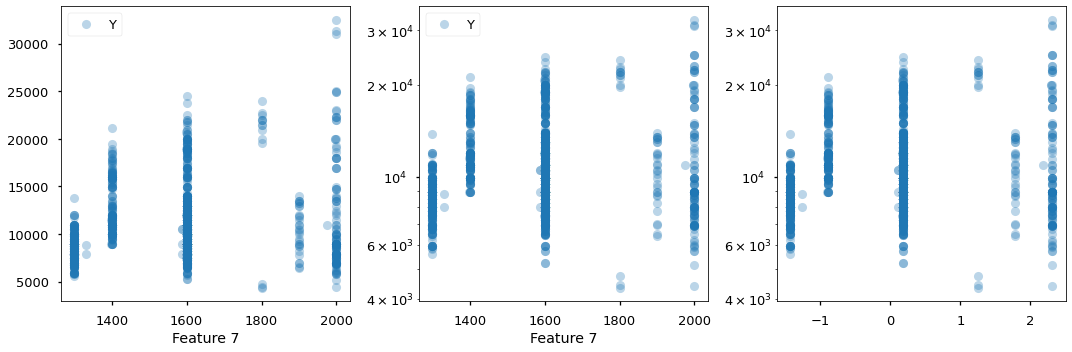

In [22]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax = ax.flatten()
df.plot("Feature 7", "Y", style="o", ax=ax[0], alpha=0.3)
df.plot("Feature 7", "Y", style="o", ax=ax[1], alpha=0.3)
ax[1].set_yscale("log")
ax[2].plot(
    StandardScaler().fit_transform(df["Feature 7"].values.reshape(-1, 1)),
    df["Y"],
    "o",
    alpha=0.3,
)
ax[2].set_yscale("log")
# ax[2].set_xscale("log", basex=2)
plt.tight_layout()

# Apply feature transformations

In [23]:
df["Y"] = df["Y"].apply(lambda x: np.log(x))
df_train, df_test = train_test_split(df, test_size=0.2, random_state=2020)
# df_train = df_train[df_train["Feature 2"] > 1000.0]

<ipython-input-24-87ac441427f9>:41: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  scatter_matrix(df2, ax=ax, alpha=0.3)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x130db8eb0>,
      dtype=object)

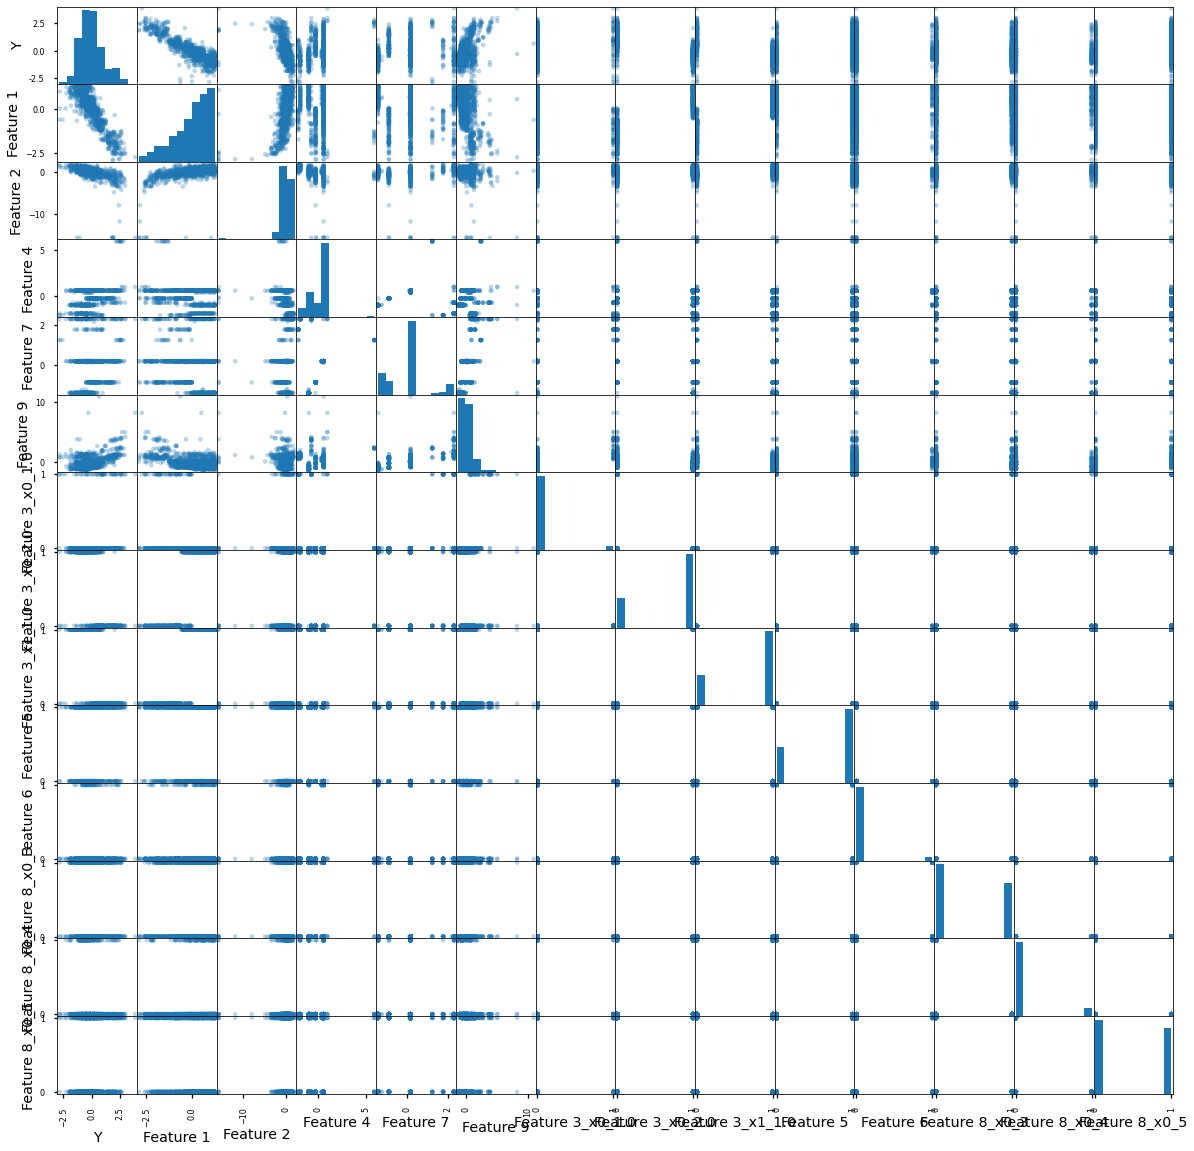

In [24]:
log_transformer = FunctionTransformer(np.log)
log1p_transformer = FunctionTransformer(lambda x: np.log2(1 + x))
# numerical_features = gen_features(columns=[[c] for c in ["Y"]], classes=[transformer])
numerical_features = [
    (["Y"], [StandardScaler()]),
    (["Feature 1"], StandardScaler()),
    (["Feature 2"], [log_transformer, RobustScaler()]),
    (["Feature 4"], [StandardScaler()]),
    (["Feature 7"], [StandardScaler()]),
    (["Feature 9"], [RobustScaler()]),
]
# numerical_features = gen_features(columns=[[c] for c in numerical_columns], classes=[StandardScaler])
categorical_columns = ["Feature 5", "Feature 6", "Feature 8"]
# categorical_features = gen_features(
#    [[c] for c in categorical_columns],
#    classes=[{"class": OneHotEncoder, "drop": "first"}],
# )
categorical_features = [
    (
        ["Feature 3"],
        [
            SimpleImputer(
                missing_values=np.nan,
                strategy="constant",
                fill_value=2,
                add_indicator=True,
            ),
            OneHotEncoder(drop="first"),
        ],
    ),
    (["Feature 5"], OneHotEncoder(drop="first")),
    (["Feature 6"], OneHotEncoder(drop="first")),
    (["Feature 8"], OneHotEncoder(drop="first")),
]
# features = numerical_features + categorical_features
features = numerical_features + categorical_features
mapper = DataFrameMapper(features, df_out=True, input_df=True)
df2 = mapper.fit_transform(df_train)

fig, ax = plt.subplots(1, 1, figsize=(20, 20))
scatter_matrix(df2, ax=ax, alpha=0.3)
# plt.tight_layout()

In [25]:
df2.columns

Index(['Y', 'Feature 1', 'Feature 2', 'Feature 4', 'Feature 7', 'Feature 9',
       'Feature 3_x0_1.0', 'Feature 3_x0_2.0', 'Feature 3_x1_1.0', 'Feature 5',
       'Feature 6', 'Feature 8_x0_3', 'Feature 8_x0_4', 'Feature 8_x0_5'],
      dtype='object')

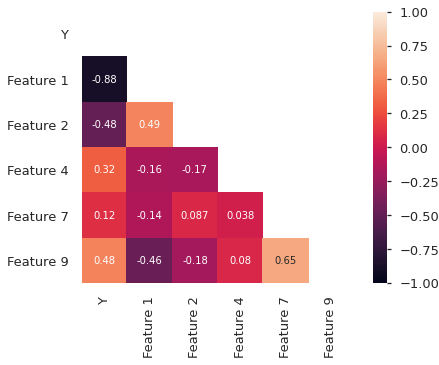

In [26]:
corr = df2[
    ["Y", "Feature 1", "Feature 2", "Feature 4", "Feature 7", "Feature 9"]
].corr()
# sns.heatmap(corr, annot=True)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(7, 5))
    ax = sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, square=True, annot=True)

In [27]:
numerical_columns = ["Feature 1", "Feature 2", "Feature 4", "Feature 7", "Feature 9"]
categorical_columns = ["Feature 5", "Feature 6", "Feature 8"]

categorical_pipe = Pipeline([("onehot", OneHotEncoder(drop="first"))])
numerical_pipe = make_pipeline(FunctionTransformer(np.log2), StandardScaler())

preprocessing = ColumnTransformer(
    [
        ("numeric", numerical_pipe, numerical_columns),
        ("cat", categorical_pipe, categorical_columns),
    ]
)

In [28]:
standard_scalar_numerical_columns = [
    "Feature 1",
    "Feature 2",
    "Feature 4",
    "Feature 7",
    "Feature 9",
]
categorical_columns = ["Feature 5", "Feature 6", "Feature 8"]

categorical_pipe = Pipeline([("onehot", OneHotEncoder(drop="first"))])
numeric_log_robust_pipe = make_pipeline(FunctionTransformer(np.log), RobustScaler())
missing_cat_pipeline = make_pipeline(
    SimpleImputer(
        missing_values=np.nan, strategy="constant", fill_value=2, add_indicator=True,
    ),
    OneHotEncoder(drop="first"),
)

preprocessing = ColumnTransformer(
    [
        (
            "numeric_standard_scalar",
            StandardScaler(),
            ["Feature 1", "Feature 4", "Feature 7"],
        ),
        ("numeric_robust", RobustScaler(), ["Feature 9"]),
        ("numeric_log_robust", numeric_log_robust_pipe, ["Feature 2"]),
        ("cat", categorical_pipe, categorical_columns),
        ("missing_cat", missing_cat_pipeline, ["Feature 3"],),
    ]
)

In [29]:
preprocessing

ColumnTransformer(transformers=[('numeric_standard_scalar', StandardScaler(),
                                 ['Feature 1', 'Feature 4', 'Feature 7']),
                                ('numeric_robust', RobustScaler(),
                                 ['Feature 9']),
                                ('numeric_log_robust',
                                 Pipeline(steps=[('functiontransformer',
                                                  FunctionTransformer(func=<ufunc 'log'>)),
                                                 ('robustscaler',
                                                  RobustScaler())]),
                                 ['Feature 2']),
                                ('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(drop='first'))]),
                                 ['Feature 5', 'Feature 6', 'Feature 8']),
                                ('missing_cat',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(add_indicator=True,
                                                                fill_value=2,
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first'))]),
                                 ['Feature 3'])])

In [30]:
def plot_prediction(y_pred, y_test, ax=None, scores=None):
    if ax is None:
        f, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.scatter(y_test, y_pred, alpha=0.3)
    ax.plot([8.5, 10.5], [8.5, 10.5], "--r")
    ax.set_ylabel("Target predicted")
    ax.set_xlabel("True Target")
    extra = plt.Rectangle(
        (0, 0), 0, 0, fc="w", fill=False, edgecolor="none", linewidth=0
    )
    if scores:
        ax.legend([extra], [scores], loc="upper left")

# Benchmark (Univariate model)

In [31]:
from sklearn.dummy import DummyRegressor
from sklearn.compose import TransformedTargetRegressor

In [32]:
X_train = df_train.drop("Y", axis=1)
y_train = df_train["Y"]
X_test = df_test.drop("Y", axis=1)
y_test = df_test["Y"]
dummy = TransformedTargetRegressor(
    regressor=Pipeline(
        [
            ("preprocessor", preprocessing),
            ("regressor", DummyRegressor(strategy="mean")),
            # ]).fit(df_train, df_train["Y"])
        ]
    ),
    transformer=StandardScaler(),
).fit(X_train, y_train)
y_pred = dummy.predict(X_test)
print(f"Training score: {dummy.score(X_train, y_train)}")
print(f"Test score 2: {dummy.score(X_test,y_test)}")

Training score: 0.0
Test score 2: -0.001905048641068774


In [33]:
dummy.score(X_train, y_train)

0.0

In [34]:
np.sqrt(mean_squared_error(y_test, y_pred))

0.2822524604738005

# Multiple Linear regresssion

Use standardization and normalization based on https://medium.com/@swethalakshmanan14/how-when-and-why-should-you-normalize-standardize-rescale-your-data-3f083def38ff

In [35]:
X_train = df_train.drop("Y", axis=1)
y_train = df_train["Y"]
X_test = df_test.drop("Y", axis=1)
y_test = df_test["Y"]
lasso_reg = TransformedTargetRegressor(
    regressor=Pipeline(
        [("preprocessor", preprocessing), ("regressor", Lasso(alpha=0.01)),]
    ),
    transformer=StandardScaler(),
).fit(X_train, y_train)
y_pred = lasso_reg.predict(X_test)
print(f"Training score: {lasso_reg.score(X_train, y_train)}")
print(f"Test score: {r2_score(y_test, y_pred)}")

Training score: 0.8161307440129657
Test score: 0.8367398158400465


In [36]:
np.sqrt(mean_squared_error(y_test, y_pred))

0.11393695142289967

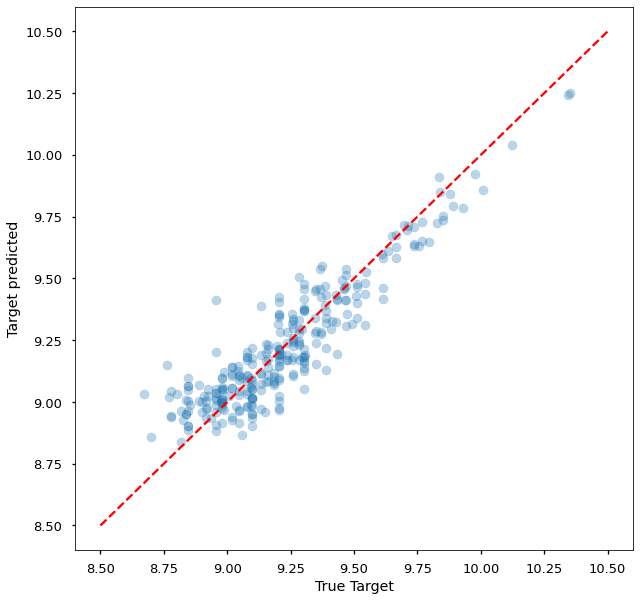

In [37]:
plot_prediction(y_pred=y_pred, y_test=y_test)

# HistGradientBooster

In [40]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

In [41]:
X_train = df_train.drop("Y", axis=1)
y_train = df_train["Y"]
X_test = df_test.drop("Y", axis=1)
y_test = df_test["Y"]
hist_reg = TransformedTargetRegressor(
    regressor=Pipeline(
        [
            ("preprocessor", preprocessing),
            ("regressor", HistGradientBoostingRegressor()),
        ]
    ),
    transformer=StandardScaler(),
).fit(X_train, y_train)
y_pred = hist_reg.predict(X_test)
print(f"Training score: {hist_reg.score(X_train, y_train)}")
print(f"Test score: {r2_score(y_test, y_pred)}")

Training score: 0.9472668264839389
Test score: 0.8543243904957898


In [42]:
hist_reg

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(transformers=[('numeric_standard_scalar',
                                                                                       StandardScaler(),
                                                                                       ['Feature '
                                                                                        '1',
                                                                                        'Feature '
                                                                                        '4',
                                                                                        'Feature '
                                                                                        '7']),
                                                                                      ('numeric_robust',
                                                                                       RobustScaler(),
                                                                                       ['Feature '
                                                                                        '9']),
                                                                                      ('numeric_log_robust',
                                                                                       Pipeline(steps=[('functiontransformer',
                                                                                                        FunctionTransformer(func=<ufunc 'log'>)),
                                                                                                       ('robustscale...
                                                                                       Pipeline(steps=[('onehot',
                                                                                                        OneHotEncoder(drop='first'))]),
                                                                                       ['Feature '
                                                                                        '5',
                                                                                        'Feature '
                                                                                        '6',
                                                                                        'Feature '
                                                                                        '8']),
                                                                                      ('missing_cat',
                                                                                       Pipeline(steps=[('simpleimputer',
                                                                                                        SimpleImputer(add_indicator=True,
                                                                                                                      fill_value=2,
                                                                                                                      strategy='constant')),
                                                                                                       ('onehotencoder',
                                                                                                        OneHotEncoder(drop='first'))]),
                                                                                       ['Feature '
                                                                                        '3'])])),
                                                     ('regressor',
                                                      HistGradientBoostingRegressor())]),
                           transformer=StandardScaler())

In [43]:
np.sqrt(mean_squared_error(y_test, y_pred))

0.10762616757083683

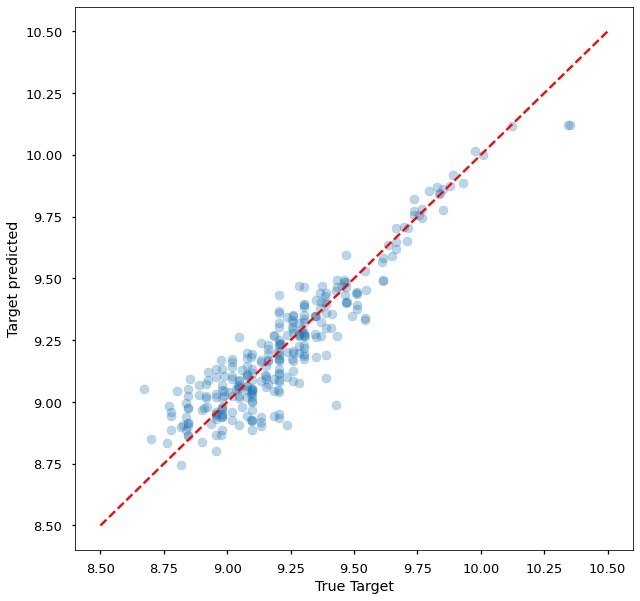

In [44]:
plot_prediction(y_pred=y_pred, y_test=y_test)

https://github.com/scikit-learn/scikit-learn/issues/15132

TODO: Read https://scikit-learn.org/stable/modules/permutation_importance.html

The impurity-based feature importance ranks the numerical features to be the most important features. As a result, the non-predictive random_num variable is ranked the most important! Source - https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py

https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-multicollinear-py

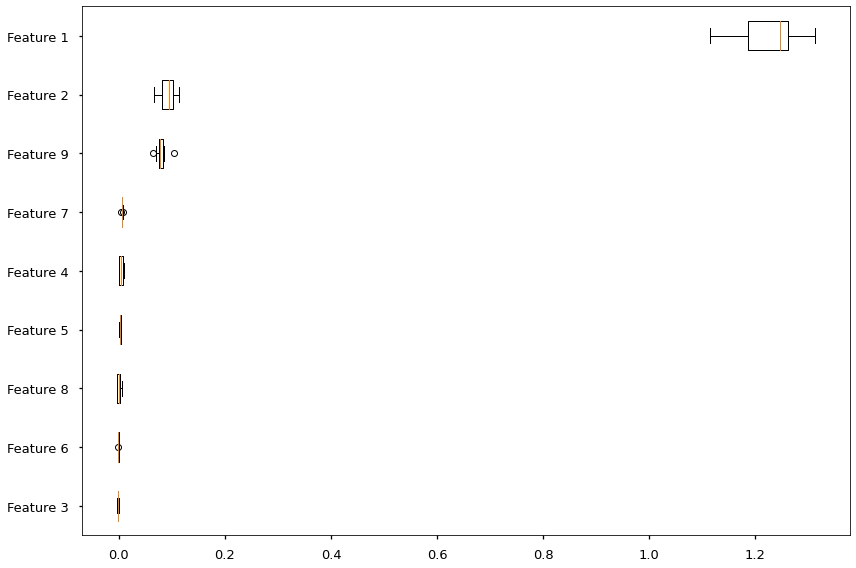

In [45]:
from sklearn.inspection import permutation_importance

est = hist_reg
result = permutation_importance(est, X_test, y_test, n_repeats=10, random_state=42)
perm_sorted_idx = result.importances_mean.argsort()

# tree_importance_sorted_idx = np.argsort(est.named_steps["regressor"].feature_importances_)
# tree_indices = np.arange(0, len(est.feature_importances_)) + 0.5

fig, ax2 = plt.subplots(1, 1, figsize=(12, 8))
ax2.boxplot(
    result.importances[perm_sorted_idx].T,
    vert=False,
    labels=X_train.columns[perm_sorted_idx],
)
fig.tight_layout()
plt.show()

# Pipeline with GridSearch CV

## ElasticNet

In [46]:
X_train = df_train.drop("Y", axis=1)
y_train = df_train["Y"]
X_test = df_test.drop("Y", axis=1)
y_test = df_test["Y"]
pipe = TransformedTargetRegressor(
    regressor=Pipeline([("preprocessor", preprocessing), ("regressor", ElasticNet()),]),
    transformer=StandardScaler(),
)
param_grid = {
    "regressor__regressor__alpha": (0.001, 0.01, 0.1, 1.0),
    "regressor__regressor__l1_ratio": (0.05, 0.2, 0.5, 0.7, 0.9, 1.0),
}
search = GridSearchCV(pipe, param_grid=param_grid, cv=5,).fit(X_train, y_train)
y_pred = search.predict(X_test)
print(f"Training score: {search.score(X_train, y_train):.3f}")
print(f"Cross-val score: {search.best_score_:.3f}")
print(f"Test score: {r2_score(y_test, y_pred):.3f}")

Training score: 0.820
Cross-val score: 0.813
Test score: 0.845


In [47]:
search.best_estimator_

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(transformers=[('numeric_standard_scalar',
                                                                                       StandardScaler(),
                                                                                       ['Feature '
                                                                                        '1',
                                                                                        'Feature '
                                                                                        '4',
                                                                                        'Feature '
                                                                                        '7']),
                                                                                      ('numeric_robust',
                                                                                       RobustScaler(),
                                                                                       ['Feature '
                                                                                        '9']),
                                                                                      ('numeric_log_robust',
                                                                                       Pipeline(steps=[('functiontransformer',
                                                                                                        FunctionTransformer(func=<ufunc 'log'>)),
                                                                                                       ('robustscale...
                                                                                       Pipeline(steps=[('onehot',
                                                                                                        OneHotEncoder(drop='first'))]),
                                                                                       ['Feature '
                                                                                        '5',
                                                                                        'Feature '
                                                                                        '6',
                                                                                        'Feature '
                                                                                        '8']),
                                                                                      ('missing_cat',
                                                                                       Pipeline(steps=[('simpleimputer',
                                                                                                        SimpleImputer(add_indicator=True,
                                                                                                                      fill_value=2,
                                                                                                                      strategy='constant')),
                                                                                                       ('onehotencoder',
                                                                                                        OneHotEncoder(drop='first'))]),
                                                                                       ['Feature '
                                                                                        '3'])])),
                                                     ('regressor',
                                                      ElasticNet(alpha=0.001,
                                                                 l1_ratio=1.0))]),
                           transformer=StandardScaler())

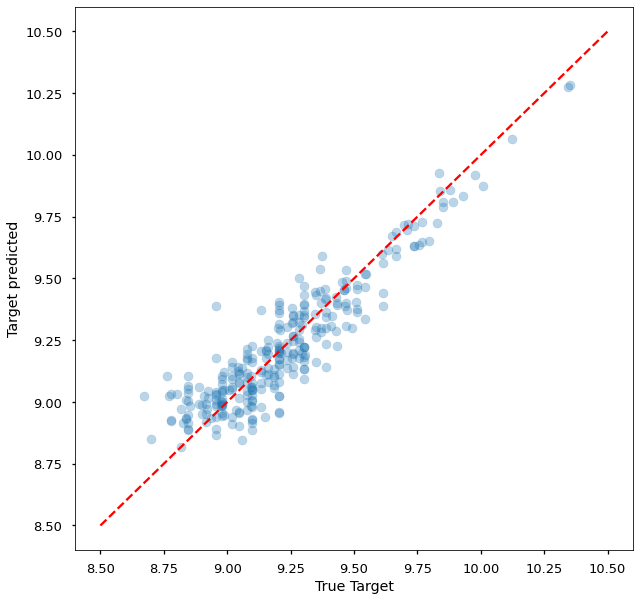

In [48]:
plot_prediction(y_pred=y_pred, y_test=y_test)

## HistGradientBooster

In [54]:
X_train = df_train.drop("Y", axis=1)
y_train = df_train["Y"]
X_test = df_test.drop("Y", axis=1)
y_test = df_test["Y"]
param_grid = {
    # "regressor__regressor__l2_regularization": [0.0, 0.1,1.0],
    # "regressor__regressor__learning_rate": [0.01, 0.1],
    "regressor__regressor__max_leaf_nodes": [5, 10, 20, 31],
    # "regressor__regressor__min_samples_leaf": [15, 20, 30, 50],
}
pipe = TransformedTargetRegressor(
    regressor=Pipeline(
        [
            ("preprocessor", preprocessing),
            ("regressor", HistGradientBoostingRegressor()),
        ]
    ),
    transformer=StandardScaler(),
)
search = GridSearchCV(pipe, param_grid=param_grid, cv=5,).fit(X_train, y_train)
y_pred = search.predict(X_test)
print(f"Training score: {search.score(X_train, y_train):.3f}")
print(f"Cross-val score: {search.best_score_:.3f}")
print(f"Test score: {r2_score(y_test, y_pred):.3f}")

Training score: 0.896
Cross-val score: 0.855
Test score: 0.872


1. The default parameters for the model would overfit. 
2. This can be seen with very high training score.
3. Searching for the best parameter, reduces the training score while keeping cross-validation score "similar"

In [55]:
search.best_estimator_

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(transformers=[('numeric_standard_scalar',
                                                                                       StandardScaler(),
                                                                                       ['Feature '
                                                                                        '1',
                                                                                        'Feature '
                                                                                        '4',
                                                                                        'Feature '
                                                                                        '7']),
                                                                                      ('numeric_robust',
                                                                                       RobustScaler(),
                                                                                       ['Feature '
                                                                                        '9']),
                                                                                      ('numeric_log_robust',
                                                                                       Pipeline(steps=[('functiontransformer',
                                                                                                        FunctionTransformer(func=<ufunc 'log'>)),
                                                                                                       ('robustscale...
                                                                                       Pipeline(steps=[('onehot',
                                                                                                        OneHotEncoder(drop='first'))]),
                                                                                       ['Feature '
                                                                                        '5',
                                                                                        'Feature '
                                                                                        '6',
                                                                                        'Feature '
                                                                                        '8']),
                                                                                      ('missing_cat',
                                                                                       Pipeline(steps=[('simpleimputer',
                                                                                                        SimpleImputer(add_indicator=True,
                                                                                                                      fill_value=2,
                                                                                                                      strategy='constant')),
                                                                                                       ('onehotencoder',
                                                                                                        OneHotEncoder(drop='first'))]),
                                                                                       ['Feature '
                                                                                        '3'])])),
                                                     ('regressor',
                                                      HistGradientBoostingRegressor(max_leaf_nodes=5))]),
                           transformer=StandardScaler())

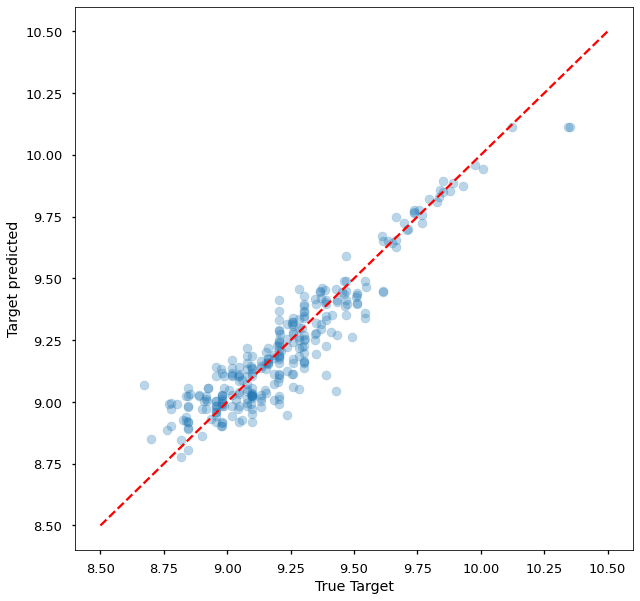

In [56]:
plot_prediction(y_pred=y_pred, y_test=y_test)

## RandomForest

In [57]:
X_train = df_train.drop("Y", axis=1)
y_train = df_train["Y"]
X_test = df_test.drop("Y", axis=1)
y_test = df_test["Y"]
param_grid = {
    "regressor__regressor__n_estimators": [10, 50, 100, 200],
    # "regressor__regressor__min_samples_split": [5, 10, 15, 20],
    #    "regressor__regressor__learning_rate": [0.01, 0.1],
    "regressor__regressor__max_leaf_nodes": [20, 30, 50, 70, 80],
    # "regressor__regressor__min_samples_leaf": [15, 20, 30, 50],
}
pipe = TransformedTargetRegressor(
    regressor=Pipeline(
        [("preprocessor", preprocessing), ("regressor", RandomForestRegressor()),]
    ),
    transformer=StandardScaler(),
)
search = GridSearchCV(pipe, param_grid=param_grid, cv=5,).fit(X_train, y_train)
y_pred = search.predict(X_test)
print(f"Training score: {search.score(X_train, y_train):.3f}")
print(f"Cross-val score: {search.best_score_:.3f}")
print(f"Test score: {r2_score(y_test, y_pred):.3f}")

Training score: 0.935
Cross-val score: 0.848
Test score: 0.871


In [58]:
search.best_estimator_

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(transformers=[('numeric_standard_scalar',
                                                                                       StandardScaler(),
                                                                                       ['Feature '
                                                                                        '1',
                                                                                        'Feature '
                                                                                        '4',
                                                                                        'Feature '
                                                                                        '7']),
                                                                                      ('numeric_robust',
                                                                                       RobustScaler(),
                                                                                       ['Feature '
                                                                                        '9']),
                                                                                      ('numeric_log_robust',
                                                                                       Pipeline(steps=[('functiontransformer',
                                                                                                        FunctionTransformer(func=<ufunc 'log'>)),
                                                                                                       ('robustscale...
                                                                                       Pipeline(steps=[('onehot',
                                                                                                        OneHotEncoder(drop='first'))]),
                                                                                       ['Feature '
                                                                                        '5',
                                                                                        'Feature '
                                                                                        '6',
                                                                                        'Feature '
                                                                                        '8']),
                                                                                      ('missing_cat',
                                                                                       Pipeline(steps=[('simpleimputer',
                                                                                                        SimpleImputer(add_indicator=True,
                                                                                                                      fill_value=2,
                                                                                                                      strategy='constant')),
                                                                                                       ('onehotencoder',
                                                                                                        OneHotEncoder(drop='first'))]),
                                                                                       ['Feature '
                                                                                        '3'])])),
                                                     ('regressor',
                                                      RandomForestRegressor(max_leaf_nodes=80))]),
                           transformer=StandardScaler())

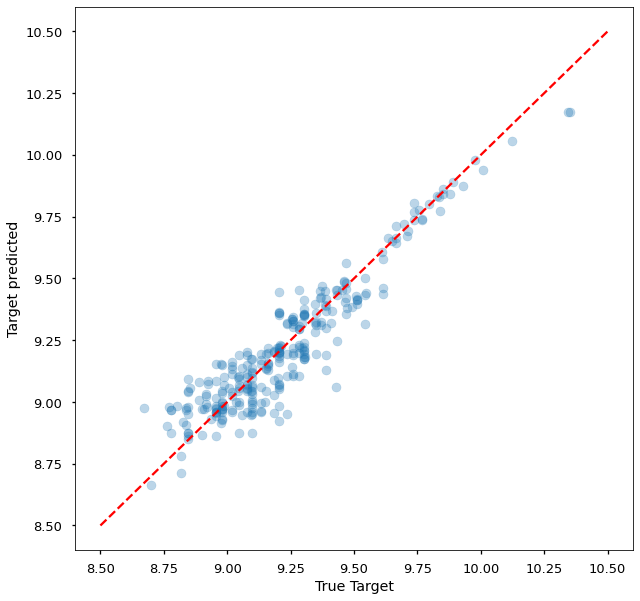

In [59]:
plot_prediction(y_pred=y_pred, y_test=y_test)

Observation:
    - Seem to predict well at high values compares to smaller values

# Putting it all together

1. Remove outiers
2. Remove unimportant features

In [25]:
X_train = df_train.drop("Y", axis=1)
y_train = df_train["Y"]
X_test = df_test.drop("Y", axis=1)
y_test = df_test["Y"]

# Preprocessing
standard_scalar_numerical_columns = [
    "Feature 1",
    "Feature 2",
    "Feature 4",
    "Feature 7",
    "Feature 9",
]
categorical_columns = ["Feature 5", "Feature 6", "Feature 8"]

categorical_pipe = Pipeline([("onehot", OneHotEncoder(drop="first"))])
numeric_log_robust_pipe = make_pipeline(FunctionTransformer(np.log), RobustScaler())
missing_cat_pipeline = make_pipeline(
    SimpleImputer(
        missing_values=np.nan, strategy="constant", fill_value=2, add_indicator=True,
    ),
    OneHotEncoder(drop="first"),
)

preprocessing = ColumnTransformer(
    [
        (
            "numeric_standard_scalar",
            StandardScaler(),
            ["Feature 1", "Feature 4", "Feature 7"],
        ),
        ("numeric_robust", RobustScaler(), ["Feature 9"]),
        ("numeric_log_robust", numeric_log_robust_pipe, ["Feature 2"]),
        ("cat", categorical_pipe, categorical_columns),
        ("missing_cat", missing_cat_pipeline, ["Feature 3"],),
    ]
)

# ElasticNet (alpha = 1.0 -> Lasso)
param_grid = {
    "regressor__regressor__alpha": (0.001, 0.01, 0.1, 1.0),
    "regressor__regressor__l1_ratio": (0.05, 0.2, 0.5, 0.7, 0.9, 1.0),
}
en_pipe = TransformedTargetRegressor(
    regressor=Pipeline([("preprocessor", preprocessing), ("regressor", ElasticNet()),]),
    transformer=StandardScaler(),
)
en_search = GridSearchCV(en_pipe, param_grid=param_grid, cv=5,)

# RandomForest
param_grid = {
    "regressor__regressor__n_estimators": [10, 50, 100, 200],
    "regressor__regressor__max_leaf_nodes": [20, 30, 50, 70, 80],
}
rf_pipe = TransformedTargetRegressor(
    regressor=Pipeline(
        [("preprocessor", preprocessing), ("regressor", RandomForestRegressor()),]
    ),
    transformer=StandardScaler(),
)
rf_search = GridSearchCV(rf_pipe, param_grid=param_grid, cv=5,)

# HistGradientBoost
param_grid = {
    # "regressor__regressor__l2_regularization": [0.0, 0.1,1.0],
    # "regressor__regressor__learning_rate": [0.01, 0.1],
    "regressor__regressor__max_leaf_nodes": [5, 10, 20, 31],
    # "regressor__regressor__min_samples_leaf": [15, 20, 30, 50],
}
hgb_pipe = TransformedTargetRegressor(
    regressor=Pipeline(
        [
            ("preprocessor", preprocessing),
            ("regressor", HistGradientBoostingRegressor()),
        ]
    ),
    transformer=StandardScaler(),
)
hgb_search = GridSearchCV(hgb_pipe, param_grid=param_grid, cv=5,)

estimators = {
    "ElasticNet": en_search,
    "RandomForest": rf_search,
    "HistGradientBoost": hgb_search,
}

fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharey=True)
for ax, (estimator_name, estimator) in zip(axes, estimators.items()):
    reg = estimator.fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    print(f"Estimator: {estimator_name}")
    print(f"Training score: {reg.score(X_train, y_train):.3f}")
    print(f"Cross-val score: {reg.best_score_:.3f}")
    print(f"Test score: {r2_score(y_test, y_pred):.3f}")
    print(f"----------")
    scores = r"$R^2$=%.3f, MAE=%.3f, MSE=%.3f" % (
        r2_score(y_test, y_pred),
        median_absolute_error(y_test, y_pred),
        mean_squared_error(y_test, y_pred),
    )
    plot_prediction(y_test=y_test, y_pred=y_pred, ax=ax, scores=scores)

NameError: name 'HistGradientBoostingRegressor' is not defined

In [49]:
cd ../src/

/Users/pushkar/Desktop/Regression/src


In [4]:
from model_turbostart.estimators import create_estimators
from model_turbostart.train import load_data, plot_prediction, train_estimators

ImportError: cannot import name 'HistGradientBoostingRegressor' from 'sklearn.ensemble' (/Users/pushkar/anaconda3/envs/regression/lib/python3.8/site-packages/sklearn/ensemble/__init__.py)

In [51]:
X_train, y_train, X_test, y_test = load_data("../data/data.csv")

# Preprocessing
categorical_columns = ["Feature 5", "Feature 6", "Feature 8"]

numeric_log_robust_pipe = make_pipeline(FunctionTransformer(np.log), RobustScaler())

missing_cat_pipeline = make_pipeline(
    SimpleImputer(
        missing_values=np.nan, strategy="constant", fill_value=2, add_indicator=True,
    ),
    OneHotEncoder(drop="first"),
)

preprocessing = ColumnTransformer(
    [
        (
            "numeric_standard_scalar",
            StandardScaler(),
            ["Feature 1", "Feature 4", "Feature 7", "Feature 9"],
        ),
        ("numeric_log_robust", numeric_log_robust_pipe, ["Feature 2"]),
        ("onehot", OneHotEncoder(drop="first"), categorical_columns),
        ("missing_cat", missing_cat_pipeline, ["Feature 3"],),
    ]
)

estimators = create_estimators(preprocessing)
preprocessing

INFO:train:Transforming Y to log(Y)
INFO:train:Splitting data as 80/20


ColumnTransformer(transformers=[('numeric_standard_scalar', StandardScaler(),
                                 ['Feature 1', 'Feature 4', 'Feature 7',
                                  'Feature 9']),
                                ('numeric_log_robust',
                                 Pipeline(steps=[('functiontransformer',
                                                  FunctionTransformer(func=<ufunc 'log'>)),
                                                 ('robustscaler',
                                                  RobustScaler())]),
                                 ['Feature 2']),
                                ('onehot', OneHotEncoder(drop='first'),
                                 ['Feature 5', 'Feature 6', 'Feature 8']),
                                ('missing_cat',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(add_indicator=True,
                                                                fill_value=2,
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first'))]),
                                 ['Feature 3'])])

Estimator: ElasticNet
Training score: 0.820
Cross-val score: 0.813
Test score: 0.845
----------
Estimator: RandomForest
Training score: 0.913
Cross-val score: 0.852
Test score: 0.877
----------
Estimator: HistGradientBoost
Training score: 0.919
Cross-val score: 0.852
Test score: 0.864
----------


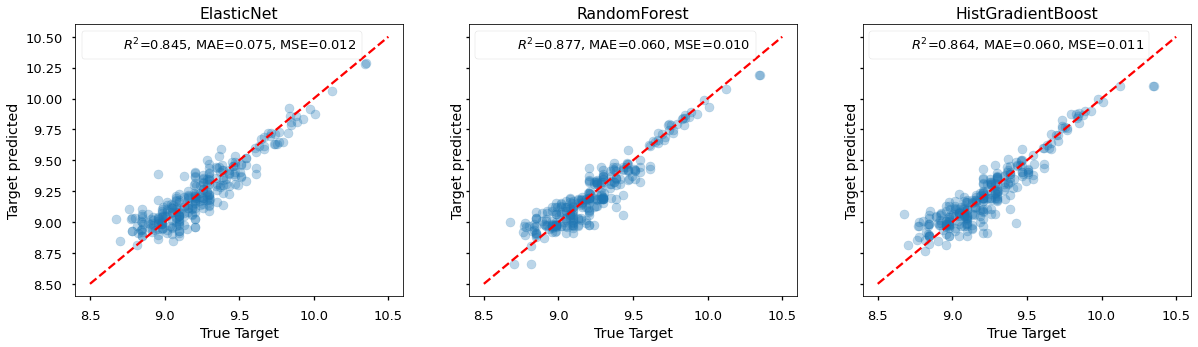

In [52]:
train_estimators(estimators, X_train, y_train, X_test, y_test)

In [76]:
estimators["HistGradientBoost"].best_estimator_

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(transformers=[('numeric_standard_scalar',
                                                                                       StandardScaler(),
                                                                                       ['Feature '
                                                                                        '1',
                                                                                        'Feature '
                                                                                        '4',
                                                                                        'Feature '
                                                                                        '7',
                                                                                        'Feature '
                                                                                        '9']),
                                                                                      ('numeric_log_robust',
                                                                                       Pipeline(steps=[('functiontransformer',
                                                                                                        FunctionTransformer(func=<ufunc 'log'>)),
                                                                                                       ('robustscaler',
                                                                                                        RobustScaler())]),
                                                                                       ['Feature '
                                                                                        '2'])...
                                                                                       ['Feature '
                                                                                        '5',
                                                                                        'Feature '
                                                                                        '6',
                                                                                        'Feature '
                                                                                        '8']),
                                                                                      ('missing_cat',
                                                                                       Pipeline(steps=[('simpleimputer',
                                                                                                        SimpleImputer(add_indicator=True,
                                                                                                                      fill_value=2,
                                                                                                                      strategy='constant')),
                                                                                                       ('onehotencoder',
                                                                                                        OneHotEncoder(drop='first'))]),
                                                                                       ['Feature '
                                                                                        '3'])])),
                                                     ('regressor',
                                                      HistGradientBoostingRegressor(l2_regularization=0.1,
                                                                                    max_iter=200,
                                                                                    max_leaf_nodes=5))]),
                           transformer=StandardScaler())

In [67]:
X_train, y_train, X_test, y_test = load_data("../data/data.csv")

# Preprocessing
categorical_columns = ["Feature 5", "Feature 6", "Feature 8"]

numeric_log_robust_pipe = make_pipeline(FunctionTransformer(np.log), RobustScaler())

missing_cat_pipeline = make_pipeline(
    SimpleImputer(
        missing_values=np.nan, strategy="constant", fill_value=2, add_indicator=True,
    ),
    OneHotEncoder(drop="first"),
)

preprocessing = ColumnTransformer(
    [
        (
            "numeric_standard_scalar",
            StandardScaler(),
            ["Feature 1", "Feature 4", "Feature 7", "Feature 9"],
        ),
        ("numeric_log_robust", numeric_log_robust_pipe, ["Feature 2"]),
        ("onehot", OneHotEncoder(drop="first"), categorical_columns),
    ]
)

estimators = create_estimators(preprocessing)
preprocessing

INFO:train:Transforming Y to log(Y)
INFO:train:Splitting data as 80/20


ColumnTransformer(transformers=[('numeric_standard_scalar', StandardScaler(),
                                 ['Feature 1', 'Feature 4', 'Feature 7',
                                  'Feature 9']),
                                ('numeric_log_robust',
                                 Pipeline(steps=[('functiontransformer',
                                                  FunctionTransformer(func=<ufunc 'log'>)),
                                                 ('robustscaler',
                                                  RobustScaler())]),
                                 ['Feature 2']),
                                ('onehot', OneHotEncoder(drop='first'),
                                 ['Feature 5', 'Feature 6', 'Feature 8'])])

Estimator: ElasticNet
Training score: 0.820
Cross-val score: 0.813
Test score: 0.845
----------
Estimator: RandomForest
Training score: 0.926
Cross-val score: 0.851
Test score: 0.876
----------
Estimator: HistGradientBoost
Training score: 0.919
Cross-val score: 0.852
Test score: 0.864
----------


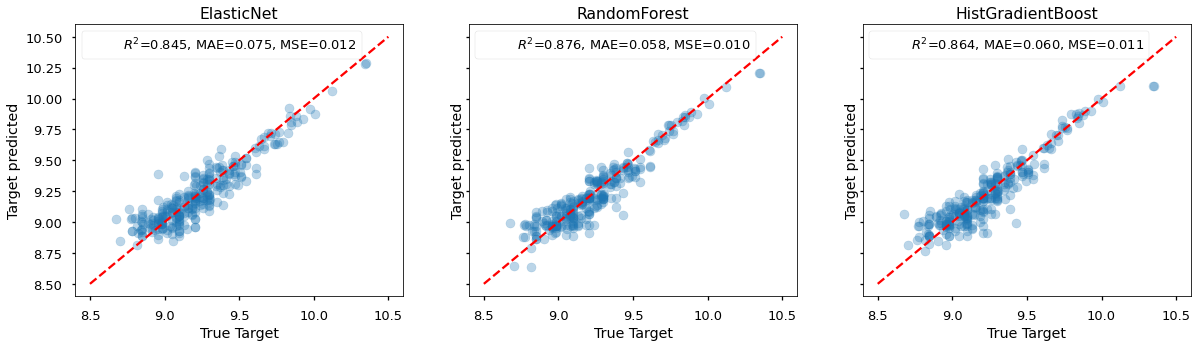

In [54]:
train_estimators(estimators, X_train, y_train, X_test, y_test)

In [55]:
estimators["HistGradientBoost"].best_estimator_

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(transformers=[('numeric_standard_scalar',
                                                                                       StandardScaler(),
                                                                                       ['Feature '
                                                                                        '1',
                                                                                        'Feature '
                                                                                        '4',
                                                                                        'Feature '
                                                                                        '7',
                                                                                        'Feature '
                                                                                        '9']),
                                                                                      ('numeric_log_robust',
                                                                                       Pipeline(steps=[('functiontransformer',
                                                                                                        FunctionTransformer(func=<ufunc 'log'>)),
                                                                                                       ('robustscaler',
                                                                                                        RobustScaler())]),
                                                                                       ['Feature '
                                                                                        '2'])...
                                                                                       OneHotEncoder(drop='first'),
                                                                                       ['Feature '
                                                                                        '5',
                                                                                        'Feature '
                                                                                        '6',
                                                                                        'Feature '
                                                                                        '8']),
                                                                                      ('missing_cat',
                                                                                       Pipeline(steps=[('simpleimputer',
                                                                                                        SimpleImputer(add_indicator=True,
                                                                                                                      fill_value=2,
                                                                                                                      strategy='constant')),
                                                                                                       ('onehotencoder',
                                                                                                        OneHotEncoder(drop='first'))]),
                                                                                       ['Feature '
                                                                                        '3'])])),
                                                     ('regressor',
                                                      HistGradientBoostingRegressor(l2_regularization=0.1,
                                                                                    max_depth=5))]),
                           transformer=StandardScaler())

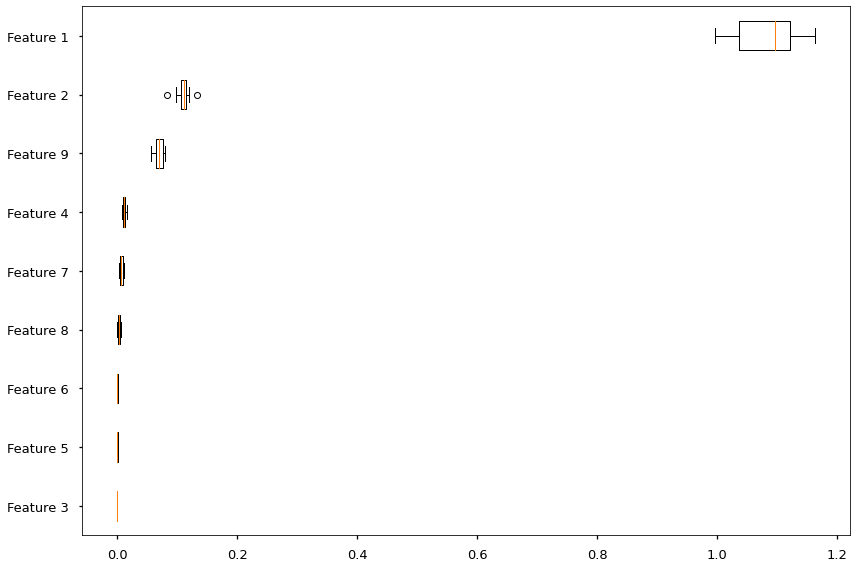

In [70]:
from sklearn.inspection import permutation_importance

est = estimators["HistGradientBoost"].best_estimator_
result = permutation_importance(est, X_test, y_test, n_repeats=10, random_state=42)
perm_sorted_idx = result.importances_mean.argsort()

fig, ax2 = plt.subplots(1, 1, figsize=(12, 8))
ax2.boxplot(
    result.importances[perm_sorted_idx].T,
    vert=False,
    labels=X_train.columns[perm_sorted_idx],
)
fig.tight_layout()
plt.show()

Testing model performance after removing outliers. 

Hypothesis - Multiple Linear regression should improve. Tree-based methods are robust

Observation - Performance seems to have degraded


INFO:train:Transforming Y to log(Y)
INFO:train:Splitting data as 80/20


Estimator: ElasticNet
Training score: 0.832
Cross-val score: 0.828
Test score: 0.844
----------


KeyboardInterrupt: 

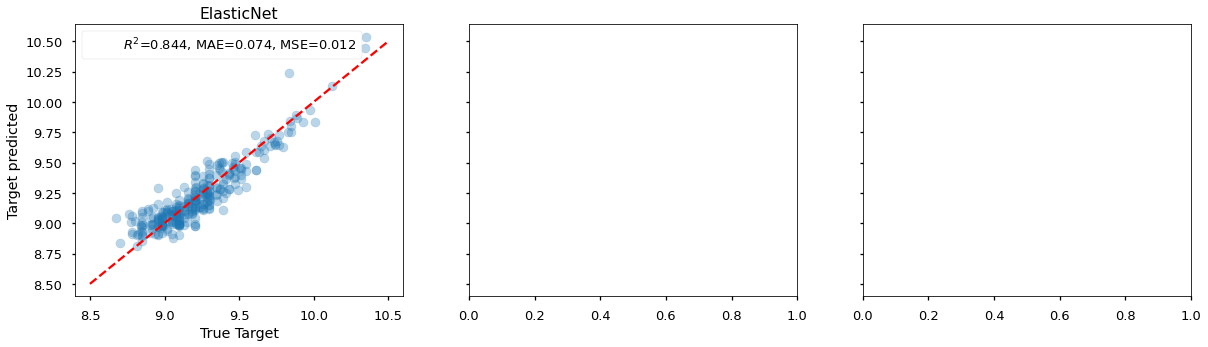

In [72]:
X_train, y_train, X_test, y_test = load_data("../data/data.csv")
non_outliers = X_train["Feature 2"] > 1000
X_train = X_train[non_outliers]
y_train = y_train[non_outliers]
train_estimators(estimators, X_train, y_train, X_test, y_test)

Remove Features 5,6,8 as they are not important based on feature importance from histgradientboost

In [89]:
X_train, y_train, X_test, y_test = load_data("../data/data.csv")

# Preprocessing
preprocessing = ColumnTransformer(
    [
        (
            "numeric_standard_scalar",
            StandardScaler(),
            ["Feature 1", "Feature 2", "Feature 9"],
        ),
    ]
)

estimators = create_estimators(preprocessing)
preprocessing

INFO:train:Transforming Y to log(Y)
INFO:train:Splitting data as 80/20


ColumnTransformer(transformers=[('numeric_standard_scalar', StandardScaler(),
                                 ['Feature 1', 'Feature 2', 'Feature 9'])])

INFO:train:Transforming Y to log(Y)
INFO:train:Splitting data as 80/20


Estimator: ElasticNet
Training score: 0.829
Cross-val score: 0.828
Test score: 0.851
----------
Estimator: RandomForest
Training score: 0.899
Cross-val score: 0.846
Test score: 0.869
----------
Estimator: HistGradientBoost
Training score: 0.890
Cross-val score: 0.852
Test score: 0.863
----------


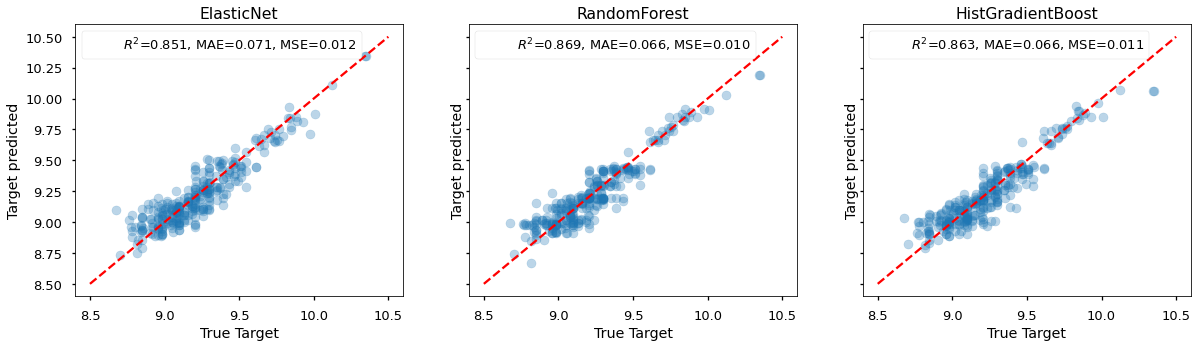

In [90]:
X_train, y_train, X_test, y_test = load_data("../data/data.csv")
train_estimators(estimators, X_train, y_train, X_test, y_test)

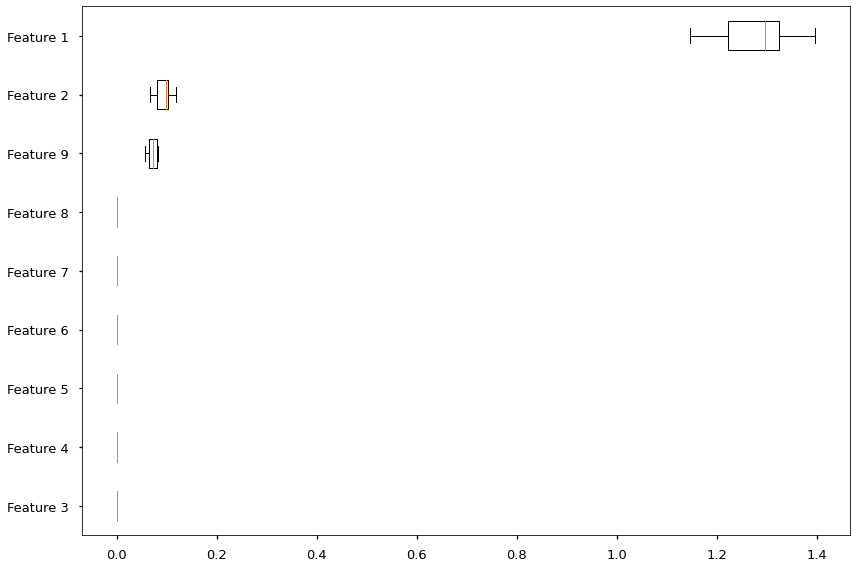

In [91]:
from sklearn.inspection import permutation_importance

est = estimators["RandomForest"].best_estimator_
result = permutation_importance(est, X_test, y_test, n_repeats=10, random_state=42)
perm_sorted_idx = result.importances_mean.argsort()

# tree_importance_sorted_idx = np.argsort(est.named_steps["regressor"].feature_importances_)
# tree_indices = np.arange(0, len(est.feature_importances_)) + 0.5

fig, ax2 = plt.subplots(1, 1, figsize=(12, 8))
ax2.boxplot(
    result.importances[perm_sorted_idx].T,
    vert=False,
    labels=X_train.columns[perm_sorted_idx],
)
fig.tight_layout()
plt.show()